Andrea Morelli 1845525 4 th Homework Big Data

In [ ]:
#the latest sklearn version is needed for the inverse of the random projection
!pip install -U scikit-learn==1.2.0

Those are the functions that allow to read the dataset , create wordcloud starting from keywords , do the elbow method both for the svd and for the k means and apply svd and k means.

In [ ]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from IPython.display import clear_output
import re
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import random_projection
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn
print(sklearn.__version__)
randomProjected=False

#read the dataset and randomly seelct part of it if you want to take just a part of it
def readDataset(percentage=0.1):
    global vectorizer
    global randomProjected
    #read X from a file
    with open('X.pickle', 'rb') as f:
        X = pickle.load(f)
    #read the vectorizer from a file
    with open('vectorizer.pickle', 'rb') as f:
        vectorizer = pickle.load(f)
    feature_names=vectorizer.get_feature_names_out(input_features=X)
    #take just a percantage of it for testing
    np.random_state=42
    rowsToRetain=int(X.shape[0]*percentage)
    X=X[np.random.choice(X.shape[0], rowsToRetain, replace=False)]
    randomProjected=False
    return X

def createWordCloud(keywords):
    # Create the wordcloud object
    wordcloud = WordCloud().generate(' '.join(keywords))
    # Display the generated wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#does the elbow method with the k means starting from min to max with step and plot the inertias for each k 
def elbowMethodMiniBatchKMeans(X,min=1,max=40,step=2,batch_size=1000):
    k=range(min,max,step)
    inertias=[]
    for i in k:
        if batch_size==0:
            km=KMeans(n_clusters=i,init='k-means++')
        else:
            km=MiniBatchKMeans(n_clusters=i,init='k-means++',batch_size=batch_size)
        km.fit(X)
        clear_output(wait=True)
        print(i,km.inertia_)
        inertias.append(km.inertia_)
        plt.plot(range(1,i+1,step),inertias,'-o')
        plt.xlabel('number of clusters, k')
        plt.ylabel('inertias')
        # plt.xticks(k[:i])
        plt.show()
        plt.clf()
        
#does the elbow method with the svd starting from min to max with step and plot the energies for each k
def elbowMethodSvd(X,min=1,max=40,step=2):
    #elbow methood on the svds
    k=range(min,max,step)
    energies=[]
    for i in k:
        svd=TruncatedSVD(n_components=i)
        svd.fit(X)
        energies.append(svd.explained_variance_ratio_.sum())
        #plot the results up to this point
        clear_output(wait=True)
        print(i,svd.explained_variance_ratio_.sum())
        plt.plot(range(1,i+1,step),energies,'-o')
        plt.xlabel('number of clusters, k')
        plt.ylabel('energy')
        # plt.xticks(k[:i])
        plt.show()
        plt.clf()

#applis the kmeans algorithm with k clusters and prints the top 20 words of each cluster, if batchsize is 0 then it uses the normal k means otherwise minibatch k means
def miniBatchKMeans(X,k=20,batch_size=1000,X_proj=None):
    global randomProjected,rp
    if batch_size==0:
        km=KMeans(n_clusters=k,init='k-means++')
    else:
        km = MiniBatchKMeans(n_clusters=k, init='k-means++',batch_size=batch_size)
    if randomProjected:
        km.fit(X_proj)
        centroids=[]
        for i in range(k):
            centroids.append(X[km.labels_==i].mean(axis=0))
        centroids=np.array(centroids)
    else:
        km.fit(X)
        centroids=km.cluster_centers_
    centroids=centroids.squeeze()
    centroids = centroids.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
    terms = vectorizer.get_feature_names_out()
    centroids=centroids.squeeze()
    for i in range(k):
        print("Cluster %d:" % i, end='')
        keywords=[]
        for ind in centroids[i, :20]:
            print(' %s' % terms[ind], end='')
            keywords.append(terms[ind])
        createWordCloud(keywords)
        print()

#applis the svd algorithm with k clusters (dimensions) and prints the top 20 words of each cluster
def truncatedSVD(X,k=20,X_proj=None):
    global randomProjected,rp
    svd = TruncatedSVD(n_components=k ,random_state=42)
    if randomProjected:
        y=svd.fit_transform(X_proj)
        components=rp.inverse_transform(svd.components_)
    else:
        y=svd.fit_transform(X)
        components=svd.components_
    print(f"Total energy retained in ratio: {svd.explained_variance_ratio_.sum()}")
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]
        print("Topic "+str(i)+": ")
        createWordCloud(i[0] for i in sorted_terms)
        s = ""
        for t in sorted_terms:
            s += t[0] + " "
        print(s)
    

connect to google drive to retrieve the preprocessed data not doing it from scratch everytime

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
%cd ../drive/My Drive/bigdatahw4

download the kaggle dataset to google drive

In [ ]:
#insert the kaggle json file in the content directory before running this cell
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

In [ ]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-books-reviews.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

read the dataset or just a portion for testing purposes

In [ ]:

percentage=1
nRows=3000001
nOfRowsToRead=int(nRows*percentage)

#read the csv text file
df = pd.read_csv('./Books_rating.csv', header=None , nrows=nOfRowsToRead)
df=df.to_numpy()

#split the data into header and data and reviews
header= df[0]
data=df[1:]
docs=data[:,-1]

print(docs.shape)

In [ ]:
#drop nan from the rows to not have problems
toDrop=[i for i,d in enumerate(docs) if type(docs[i])!=str]
docs=np.delete(docs,toDrop)

preprocess the data with tfidfVectorizer after appling lowercase, removing non alphabetic characters, removing stopwords and lemmatizing

In [ ]:
#lowercase the reviews
for i in range(len(docs)):
  docs[i] = docs[i].lower()

print("lowercase done")

#remove non alphabetic characters
for i in range(len(docs)):
  docs[i] = re.sub(r"[^a-zA-Z'\n ]", "", docs[i])

print("remove non alphabetic characters done")

#remove contractions
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

# Regular expression for finding contractions
def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

docs = [multiple_replace(contractions_dict, doc) for doc in docs] # Removing contractions

print("contractions done")

#remove \n
docs = [re.sub(r"[^a-zA-Z ]", " ", doc) for doc in docs]

#remove stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stopwords = nltk.corpus.stopwords.words('english') # Returns a list
stopwords = set(stopwords) # We want a set, because this is implemented with a hash table
                           # Checking the if condition in rem_stop costs O(1) in this way

def rem_stop(doc):
   word_list = word_tokenize(doc)
   cleaned_doc = ""
   for word in word_list:
     if word not in stopwords:
       cleaned_doc += " " + word
   return cleaned_doc


docs = [rem_stop(doc) for doc in docs]

print("stopwords done")

#lemmatiation
lemmatizer = WordNetLemmatizer()
for i in range(len(docs)):
    word_list = word_tokenize(docs[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    docs[i] = lemmatized_doc  

print("lemmetizer done")

#tfidf vectorization
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=5) ## Corpus is in English
X = vectorizer.fit_transform(docs)

print("vectorizer done")

print(X.shape)

writes the preprocessed data to the drive

In [ ]:
# write X to a file
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)
#save the fitted vectorizer to not redo the preprocessing again
with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

use the elbow method to a portion of the dataset to find the best number of k

In [ ]:
X=readDataset(0.1)

In [ ]:
elbowMethodMiniBatchKMeans(X,1,40,2,1000)

this is the results using min 1 max 200 and step 20 with batchsize 30000 if you dont want to run the above cell
the elbow is not that clear as one can see but the inertias go down in a faster way in the first 25 inertias

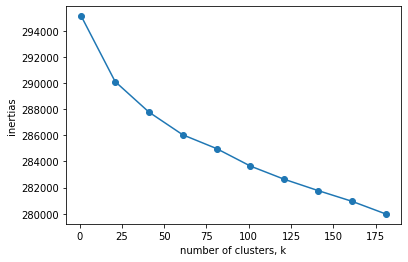

use the elbow method to a portion of the dataset to find the best number of k with random projections

In [ ]:
X=readDataset(0.1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
elbowMethodMiniBatchKMeans(X_proj,1,40,2,1000)

use the elbow method to a portion of the dataset to find the best k with the svd

In [ ]:
X=readDataset(0.1)

In [ ]:
elbowMethodSvd(X,1,40,2)

this the result of the elbow method with svd using min 1 max 500 and step size of 50
as you can see the the elbow is not that pronounced but the retrieved energy increases a lot in the first 50 components

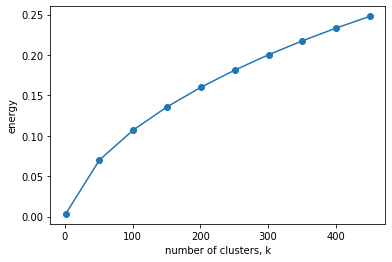

use the elbow method to a portion of the dataset to find the best k with the svd with random projections

In [ ]:
X=readDataset(0.1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
elbowMethodSvd(X_proj,1,40,2)

apply minibatch k means

In [ ]:
X=readDataset(1)

In [ ]:
miniBatchKMeans(X,20,1000)

apply truncated svd

In [ ]:
X=readDataset(1)

In [ ]:
truncatedSVD(X,20)

apply random projection and then k means

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
miniBatchKMeans(X,20,30000,X_proj)

apply random projection and then truncated svd

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
truncatedSVD(X,20,X_proj)

apply svd and then k means (results are horrible its there just because i used it and saw that nothing would come out of it)
its probabily because the svd is not able to keep most of the energy in the first components like for example in the images where most of the energy 90% is kept
at the first like 100 components.
In this case with 500 components i would retrieve only the 30% of the energy and it's not enought to cluster the data correctly

In [ ]:
X=readDataset(0.01)

In [ ]:
#apply svd to do dimensionality reduction and then k means to classify the data
newDimensions=200
k=20
batchSize=1000
svd=TruncatedSVD(n_components=newDimensions)
X=svd.fit_transform(X)
if batchSize==0:
    km=KMeans(n_clusters=k,init='k-means++')
else:
    km=MiniBatchKMeans(n_clusters=k,batch_size=batchSize,init='k-means++')
km.fit(X)
centroids=km.cluster_centers_
centroids=svd.inverse_transform(centroids).astype(int)
terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(centroids):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    createWordCloud(i[0] for i in sorted_terms)
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)


The best performances are reached using random projection and the the k means algorithm. 
The random projection acts as noise reduction reducing the dimensionality of the dataset and the k means algorithm is able to find the clusters.
Using 100 clusters we can clearly see the topics of the reviews.
The performaces are worse if we use less components of the random projection and a smaller batch size.

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=2000)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
miniBatchKMeans(X,100,100000,X_proj)